In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib as mpl
# print(mpl.rcParams.keys())
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['font.family'] = 'serif'

In [3]:
# Import sys, then tell python where to find the nEXO-specific classes
import sys
sys.path.append('/g/g99/jamil1/lustre1/sensitivity/modules')

In [4]:
bkg_shape_err = 2.5
input_table = '/usr/workspace/wsa/nexo/lenardo1/baseline2019_third_pass/ComponentsTable_D-023_merged-v5_final_cuts_finer_binning.h5' 
xe137_scale_factor = 1.0

Number from the 2017 sensitivity paper, gotten from digitizing Figure 8 from https://arxiv.org/abs/1710.05075

In [5]:
Mass2017 = [0.503834,1.00329,1.50274,2.00219,2.50164,3.00110,3.87295]
Bkg2017 = [0.000105991,0.000138291,0.000207821,0.000353783,0.000563511,0.000853902,0.00188091]

In [6]:
# Import useful libraries for analysis
import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Import the nEXO sensitivity classes
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

In [8]:
# Create the workspace
workspace = nEXOFitWorkspace.nEXOFitWorkspace('../../config/Sensitivity2020_config.yaml')
workspace.livetime = 10.0 * 365. * 24. * 60. * 60.
workspace.LoadComponentsTableFromFile(input_table)
workspace.CreateGroupedPDFs()


Loading input data froma previously-generated components table....

Loaded dataframe with 171 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']

Creating grouped PDFs....
	Group:               	Expected Counts:
	Far                  	       14577.08
	Vessel_Th232         	        3033.41
	Vessel_U238          	       17225.12
	Internals_U238       	       21515.41
	Internals_Th232      	        4255.53
	FullTPC_Co60         	         186.43
	FullTPC_K40          	    39908168.08
	Rn222                	       18706.27
	FullLXeBb2n          	    14544525.50
	FullLXeBb0n          	           0.00
	B8nu                 	          11.88
	Xe137                	          51.21
	Total Sum            	    5453

In [9]:
rho_xe = 3.057 # in g/cm^3

tpc_diam = 127.7 # in cm
tpc_height = 118.3 # in cm
ring_gap = 7.185 # in cm

def GetXenonMass(ZStandoff, RStandoff):
    Mass = rho_xe * ( np.pi * (tpc_diam/2.0 - ring_gap - RStandoff)**2 * (tpc_height - 2*ZStandoff) )
    return Mass/1000.0

In [10]:
MassXe = []
Standoff = np.arange(2,50,0.1)
for x in Standoff:
    MassXe.append(GetXenonMass(x,x))
MassXe = np.array(MassXe)

In [11]:
StandoffVals = []
FiducialMass = [500,1000,1500,2000,2500,3000,3281]
# FiducialMass = np.arange(100,3001,100)
# FiducialMass = np.append(FiducialMass,3281)

for ii in FiducialMass: 
    Diff = np.abs(MassXe - ii)
    Cut = np.where(Diff == np.min(Diff))[0][0]
    print(ii, MassXe[Cut], Standoff[Cut])
    StandoffVals.append(Standoff[Cut])
StandoffVals = np.array(StandoffVals)*10

500 501.71371814577196 27.800000000000022
1000 1002.8304231905673 20.100000000000016
1500 1503.5626445375349 14.700000000000012
2000 2004.2646195712946 10.400000000000007
2500 2500.251173876373 6.800000000000004
3000 3004.52420757976 3.6000000000000014
3281 3280.274944309186 2.0


In [20]:
BkgIndex = {}
bb0n_count = {} 
for ii,FM in enumerate(FiducialMass): 
#     roi_dict = { 'DNN':         [0.85,1.],
#              'Energy (keV)':  [ 2428.89, 2486.77 ], 
#              'Standoff (mm)': [ StandoffVals[ii], 650. ] }
    roi_dict = { 'DNN':         [0.85,1.],
             'Energy (keV)':  [ 2435.0, 2475.0 ], 
             'Standoff (mm)': [ StandoffVals[ii], 1000. ] }
    BkgIndex[FM] = {}
    BkgIndex[FM]['std'] = StandoffVals[ii]
    BkgIndex[FM]['dict'] = roi_dict
    
    
    workspace.DefineROI( roi_dict )
    
    likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
    likelihood.AddPDFDataframeToModel(workspace.df_group_pdfs)
    
#     sig_idx = likelihood.model.GetVariableIndexByName( 'Bb0n' )
#     likelihood.model.variable_list[sig_idx]['Value'] = 0.0
    
    likelihood.model.GenerateModelDistribution()
    bkg_in_roi = likelihood.model.GetIntegralInBinRange( workspace.GetROIBinIndices() )
    print(ii,FM, bkg_in_roi)
    
    BkgIndex[FM]['cts'] = bkg_in_roi/FM/10.0
    
    
#     for component in likelihood.model.variable_list:
# #         print('****************************************************************************************\n')
#         if 'Shape' in component['Name']: continue
#         num_counts_in_roi = likelihood.model.GetComponentIntegralInBinRange( \
#                                                 component['Name'], workspace.GetROIBinIndices() )
#         print('{:<20}\t{:>10.4}\t{:>10.4}%'.format( component['Name']+':', num_counts_in_roi, int(1000*num_counts_in_roi/total_bkg_in_roi)/10. ) )
#         if component['Name'] == 'Num_FullLXeBb0n': 
#             bb0n_count[FM] = num_counts_in_roi
#     print('****************************************************************************************\n')




DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.85,      1.0
Energy (keV):
	Input ROI boundaries:    2435.0,   2475.0
	Actual ROI boundaries:   2435.0,   2475.0
Standoff (mm):
	Input ROI boundaries:     278.0,   1000.0
	Actual ROI boundaries:    280.0,    650.0
0 500 0.44382172329152336
DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.85,      1.0
Energy (keV):
	Input ROI boundaries:    2435.0,   2475.0
	Actual ROI boundaries:   2435.0,   2475.0
Standoff (mm):
	Input ROI boundaries:     201.0,   1000.0
	Actual ROI boundaries:    210.0,    650.0
1 1000 1.6454382729717751
DNN:
	Input ROI boundaries:      0.85,      1.0
	Actual ROI boundaries:     0.85,      1.0
Energy (keV):
	Input ROI boundaries:    2435.0,   2475.0
	Actual ROI boundaries:   2435.0,   2475.0
Standoff (mm):
	Input ROI boundaries:     147.0,   1000.0
	Actual ROI boundaries:    150.0,    650.0
2 1500 3.732435485605653
DNN:
	Input ROI boundaries:      0.85,      1.0

In [21]:
print(bb0n_count)
for ii,key in enumerate(bb0n_count.keys()):
#     print(key, bb0n_count[key]/bb0n_count[3281] , bb0n_count[key]/bb0n_count[3281]*96.3)
    print("%.2f" % (bb0n_count[key]/bb0n_count[3281]*0.963))

{}


[8.876434465830467e-05, 0.0001645438272971775, 0.0002488290323737102, 0.0003662490625767398, 0.0005697127266064489, 0.0008670592456069043, 0.0012234538055755657]
[ 500 1000 1500 2000 2500 3000 3281]


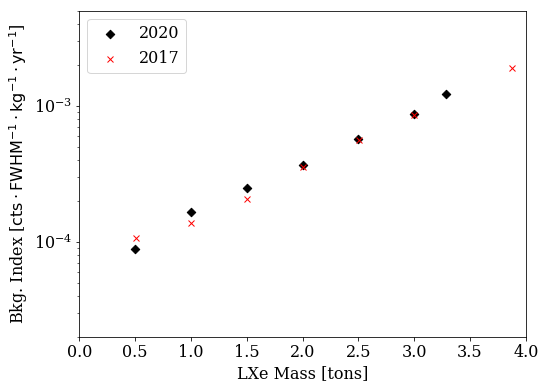

In [22]:
Mass2020 = [x/1000.0 for x in BkgIndex.keys()]
Bkg2020 = [BkgIndex[x]['cts'] for x in BkgIndex.keys()]
print(Bkg2020)
print(np.array(FiducialMass))

plt.figure(figsize=(8,6))
plt.scatter(Mass2020, Bkg2020, color='k', label='2020', marker='D')
plt.scatter(Mass2017, Bkg2017, color='r', label='2017', marker='x')

plt.yscale('log')
plt.xlim(0,4)
plt.ylim(2E-5,5E-3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('LXe Mass [tons]', fontsize=16)
plt.ylabel(r'Bkg. Index [$\mathrm{cts}\cdot \mathrm{FWHM}^{-1}\cdot \mathrm{kg}^{-1} \cdot \mathrm{yr}^{-1}$]', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.savefig('bkg_index_comparison.pdf', bbox_inches='tight')


1.0477137205409568


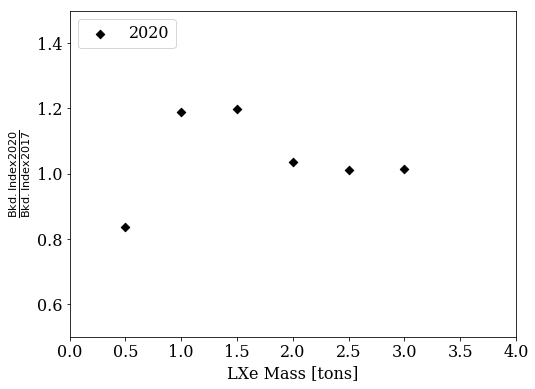

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(Mass2020[:-1], np.array(Bkg2020[:-1])/np.array(Bkg2017[:-1]), color='k', label='2020', marker='D')
# plt.scatter(Mass2017, Bkg2017, color='r', label='2017', marker='x')

# plt.yscale('log')
plt.xlim(0,4)
plt.ylim(0.5,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('LXe Mass [tons]', fontsize=16)
plt.ylabel(r'$\frac{\mathrm{Bkd. Index 2020}}{\mathrm{Bkd. Index 2017}}$', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.savefig('bkg_index_comparison_rel.pdf', bbox_inches='tight')

print(np.mean(np.array(Bkg2020[:-1])/np.array(Bkg2017[:-1])))